## Project 1
### PGA Tour Golf Stats

In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
import os
import seaborn as sns

In [3]:
# Declare input file paths and file names
pga_data_hist_file = os.path.join("PGA_Data_Historical.csv")
player_exp_file = os.path.join("player_experience_data.csv")

In [4]:
# Load main player and stat data into dataframe
all_pga_data_df = pd.read_csv(pga_data_hist_file)

# Load player experience lookup table
player_exp_df = pd.read_csv(player_exp_file)


In [5]:
# Merge player experience into main dataframe
all_pga_data_df = all_pga_data_df.merge(player_exp_df, how='left', on="Player Name")

all_pga_data_df.head()


,Player Name,Season,Statistic,Variable,Value,Exp-Before-2010,Exp-Less_Eq-2012,Exp-Less_Eq-2015,Exp-Less_Eq-2018
0,Robert Garrigus,2010,Driving Distance,Driving Distance - (ROUNDS),71,4.0,7.0,10.0,13.0
1,Bubba Watson,2010,Driving Distance,Driving Distance - (ROUNDS),77,4.0,7.0,10.0,13.0
2,Dustin Johnson,2010,Driving Distance,Driving Distance - (ROUNDS),83,2.0,5.0,8.0,11.0
3,Brett Wetterich,2010,Driving Distance,Driving Distance - (ROUNDS),54,6.0,9.0,9.0,9.0
4,J.B. Holmes,2010,Driving Distance,Driving Distance - (ROUNDS),100,4.0,7.0,10.0,13.0


In [6]:
# Create a filtered dataframe with only the stats we are interested in

# Define list of stats to keep
keep_variable_stats =  ["Season",
                        "Driving Distance - (AVG.)",
                        "Driving Distance - (TOTAL DRIVES)",
                        "Total Driving - (TOTAL)",
                        "Total Driving - (DISTANCE RANK)",
                        "Total Driving - (ACCURACY RANK)",
                        "Smash Factor - (AVG.)",
                        "Short Game Rating - (RATING)",
                        "Proximity to Hole (ARG) - (AVG DTP)",
                        "Total Putting - (TOTAL)",
                        "Putting Average - (AVG)",
                        "Total Money (Official and Unofficial) - (MONEY)"]

# Define count of stats we are keeping for each player
desired_var_stats_cnt = len(keep_variable_stats)

# Create filtered dataframe
temp_filtered_stats = all_pga_data_df.copy()
temp_filtered_stats = temp_filtered_stats.loc[temp_filtered_stats["Variable"].isin(keep_variable_stats),:]

# Drop the Statistic column, and just keep the Variable column
temp_filtered_stats.drop(["Statistic"], axis=1, inplace=True)

# Rename Variable column
temp_filtered_stats.rename(columns={"Variable" : "Statistic"}, inplace=True)

temp_filtered_stats.head()

,Player Name,Season,Statistic,Value,Exp-Before-2010,Exp-Less_Eq-2012,Exp-Less_Eq-2015,Exp-Less_Eq-2018
192,Robert Garrigus,2010,Driving Distance - (AVG.),315.5,4.0,7.0,10.0,13.0
193,Bubba Watson,2010,Driving Distance - (AVG.),309.8,4.0,7.0,10.0,13.0
194,Dustin Johnson,2010,Driving Distance - (AVG.),308.5,2.0,5.0,8.0,11.0
195,Brett Wetterich,2010,Driving Distance - (AVG.),307.3,6.0,9.0,9.0,9.0
196,J.B. Holmes,2010,Driving Distance - (AVG.),307.2,4.0,7.0,10.0,13.0


In [7]:
# Create new dataframe to move our statistics from row values to columns

# Define columns of the new dataframe
desired_columns_lst = ["Player Name",
                       "Season",
                       "Driving Distance - (AVG.)", 
                       "Driving Distance - (TOTAL DRIVES)",
                       "Total Driving - (TOTAL)",
                       "Total Driving - (DISTANCE RANK)",
                       "Total Driving - (ACCURACY RANK)",
                       "Smash Factor - (AVG.)",
                       "Short Game Rating - (RATING)",
                       "Proximity to Hole (ARG) - (AVG DTP)",
                       "Total Putting - (TOTAL)",
                       "Putting Average - (AVG)",
                       "Total Money (Official and Unofficial) - (MONEY)",
                       "Exp-Before-2010",
                       "Exp-Less_Eq-2012",
                       "Exp-Less_Eq-2015",
                       "Exp-Less_Eq-2018"]
                
cln_all_pga_data_df = pd.DataFrame(columns = desired_columns_lst)


for index, rows in temp_filtered_stats.iterrows():  
    # Search if name and season is in the dataframe, if not add
    search = cln_all_pga_data_df.loc[(cln_all_pga_data_df["Player Name"] == rows["Player Name"]) & (cln_all_pga_data_df["Season"] == rows["Season"])]
    if len(search) == 0:
        # Name and season not found.  Insert name, season, and statistic
        data = [{"Player Name" : rows["Player Name"],
                 "Season" : rows["Season"],
                 rows["Statistic"] : rows["Value"],
                 "Exp-Before-2010" : rows["Exp-Before-2010"],
                 "Exp-Less_Eq-2012" : rows["Exp-Less_Eq-2012"],
                 "Exp-Less_Eq-2015" : rows["Exp-Less_Eq-2015"],
                 "Exp-Less_Eq-2018" : rows["Exp-Less_Eq-2018"]}]            
        cln_all_pga_data_df = cln_all_pga_data_df.append(data, ignore_index=True, sort=False)
    else:
        # Name and season found.  Just add the statistic
        cln_all_pga_data_df.loc[(cln_all_pga_data_df["Player Name"] == rows["Player Name"]) & (cln_all_pga_data_df["Season"] == rows["Season"]), rows["Statistic"]] = rows["Value"]    



In [8]:
# Data cleaning - Drop rows with NaN values
cln_all_pga_data_df.dropna(axis=0, how='any', inplace=True)


# Data cleaning - Convert the Proximity to Hole (ARG) - (AVG DTP) to inches
# Define function to perform conversion
def conv_dtp_to_inches(input_dtp):
    split_str = input_dtp.split("' ")
    feet = float(split_str[0])
    inches = float(split_str[1].replace("\"",""))
    return (12 * feet) + inches

cln_all_pga_data_df["Proximity to Hole (ARG) - (AVG DTP) (IN)"] = cln_all_pga_data_df["Proximity to Hole (ARG) - (AVG DTP)"].apply(lambda x:conv_dtp_to_inches(x))

# Drop old Proximity to Hole (ARG) - (AVG DTP) column
cln_all_pga_data_df.drop("Proximity to Hole (ARG) - (AVG DTP)", axis=1, inplace=True)


# Data cleaning - Remove dollar sign and commas from earnings column

cln_all_pga_data_df["Total Money (Official and Unofficial) - (MONEY)"] = cln_all_pga_data_df["Total Money (Official and Unofficial) - (MONEY)"].str.replace('$','')
cln_all_pga_data_df["Total Money (Official and Unofficial) - (MONEY)"] = cln_all_pga_data_df["Total Money (Official and Unofficial) - (MONEY)"].str.replace(',','')


In [9]:
# Rearrange columns
column_order = ["Player Name",
                "Season",
                "Driving Distance - (AVG.)",
                "Driving Distance - (TOTAL DRIVES)",
                "Total Driving - (TOTAL)",
                "Total Driving - (DISTANCE RANK)",
                "Total Driving - (ACCURACY RANK)",
                "Smash Factor - (AVG.)",
                "Short Game Rating - (RATING)",
                "Proximity to Hole (ARG) - (AVG DTP) (IN)",
                "Total Putting - (TOTAL)",
                "Putting Average - (AVG)",
                "Total Money (Official and Unofficial) - (MONEY)",
                "Exp-Before-2010",
                "Exp-Less_Eq-2012",
                "Exp-Less_Eq-2015",
                "Exp-Less_Eq-2018"]

cln_all_pga_data_df = cln_all_pga_data_df.reindex(columns=column_order)


In [10]:
cln_all_pga_data_df.head()

,Player Name,Season,Driving Distance - (AVG.),Driving Distance - (TOTAL DRIVES),Total Driving - (TOTAL),Total Driving - (DISTANCE RANK),Total Driving - (ACCURACY RANK),Smash Factor - (AVG.),Short Game Rating - (RATING),Proximity to Hole (ARG) - (AVG DTP) (IN),Total Putting - (TOTAL),Putting Average - (AVG),Total Money (Official and Unofficial) - (MONEY),Exp-Before-2010,Exp-Less_Eq-2012,Exp-Less_Eq-2015,Exp-Less_Eq-2018
0,Robert Garrigus,2010,315.5,130,176,1,175,1.475,5.5,103.0,245.2,1.786,1583275,4.0,7.0,10.0,13.0
1,Bubba Watson,2010,309.8,154,178,2,176,1.477,5.6,97.0,219.9,1.763,3655665,4.0,7.0,10.0,13.0
2,Dustin Johnson,2010,308.5,164,175,3,172,1.479,5.8,94.0,239.6,1.767,5280289,2.0,5.0,8.0,11.0
3,Brett Wetterich,2010,307.3,108,166,4,162,1.477,6.0,97.0,200.0,1.801,510672,6.0,9.0,9.0,9.0
4,J.B. Holmes,2010,307.2,200,188,5,183,1.480,6.2,84.0,234.8,1.770,2746248,4.0,7.0,10.0,13.0


In [11]:
# Convert stat columns to appropriate datatypes

# Define a conversion dictionary
conversion_dict = {"Season" : "int64",
                   "Driving Distance - (AVG.)" : "float64",
                   "Driving Distance - (TOTAL DRIVES)" : "int64",
                   "Total Driving - (TOTAL)" : "int64",
                   "Total Driving - (DISTANCE RANK)" : "int64",
                   "Total Driving - (ACCURACY RANK)" : "int64",
                   "Smash Factor - (AVG.)" : "float64",
                   "Short Game Rating - (RATING)" : "float64",
                   "Proximity to Hole (ARG) - (AVG DTP) (IN)" : "float64",
                   "Total Putting - (TOTAL)" : "float64",
                   "Putting Average - (AVG)" : "float64",
                   "Total Money (Official and Unofficial) - (MONEY)" : "float64",
                   "Exp-Before-2010" : "int64",
                   "Exp-Less_Eq-2012" : "int64",
                   "Exp-Less_Eq-2015" : "int64",
                   "Exp-Less_Eq-2018" : "int64"                   
                 }

# Convert column datatypes, ignore errors and keep any NaNs if they exist
cln_all_pga_data_df = cln_all_pga_data_df.astype(conversion_dict, errors="ignore")

cln_all_pga_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1661 entries, 0 to 3488
Data columns (total 17 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Player Name                                      1661 non-null   object 
 1   Season                                           1661 non-null   int64  
 2   Driving Distance - (AVG.)                        1661 non-null   float64
 3   Driving Distance - (TOTAL DRIVES)                1661 non-null   int64  
 4   Total Driving - (TOTAL)                          1661 non-null   int64  
 5   Total Driving - (DISTANCE RANK)                  1661 non-null   int64  
 6   Total Driving - (ACCURACY RANK)                  1661 non-null   int64  
 7   Smash Factor - (AVG.)                            1661 non-null   float64
 8   Short Game Rating - (RATING)                     1661 non-null   float64
 9   Proximity to Hole (ARG) - (AVG

In [12]:
# Output to CSV or Read from CSV using this cell

#cln_all_pga_data_df.to_csv("output_data/cln_all_pga_data_df.csv", index=False)

In [13]:
# If we need these, this is how to split our dataframe into groups

# Create dataframes for groups of 3 years
cln_2010_2012_df = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"].isin(["2010", "2011", "2012"]),:]
cln_2010_2012_df.reset_index(inplace=True)

cln_2013_2015_df = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"].isin(["2013", "2014", "2015"]),:]
cln_2013_2015_df.reset_index(inplace=True)

cln_2016_2018_df = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"].isin(["2016", "2017", "2018"]),:]
cln_2016_2018_df.reset_index(inplace=True)

# Create dataframes for groups of 4 years
cln_2011_2014_df = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"].isin(["2011", "2012", "2013", "2014"]),:]
cln_2011_2014_df.reset_index(inplace=True)

cln_2015_2018_df = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"].isin(["2015", "2016", "2017", "2018"]),:]
cln_2015_2018_df.reset_index(inplace=True)

    

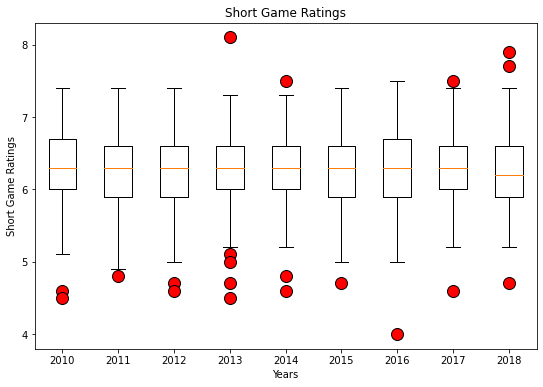

In [18]:
# Short Game Performance
# Boxplot of short game data across years

# Short Game Rating - (RATING)
short_game_2010 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2010,"Short Game Rating - (RATING)"]
short_game_2011 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2011,"Short Game Rating - (RATING)"]
short_game_2012 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2012,"Short Game Rating - (RATING)"]
short_game_2013 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2013,"Short Game Rating - (RATING)"]
short_game_2014 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2014,"Short Game Rating - (RATING)"]
short_game_2015 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2015,"Short Game Rating - (RATING)"]
short_game_2016 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2016,"Short Game Rating - (RATING)"]
short_game_2017 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2017,"Short Game Rating - (RATING)"]
short_game_2018 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2018,"Short Game Rating - (RATING)"]

short_game_boxplot = [short_game_2010, short_game_2011,
                      short_game_2012, short_game_2013,
                      short_game_2014, short_game_2015,
                      short_game_2016, short_game_2017,
                      short_game_2018]

# Create figure and axes
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)

# Create the boxplot
boxplot = ax.boxplot(short_game_boxplot, flierprops=dict(markerfacecolor='r', marker='o', markersize=12.0))
ax.set_xticklabels([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])
ax.set(title = "Short Game Ratings",
       xlabel = "Years",
       ylabel = "Short Game Ratings")
plt.show()

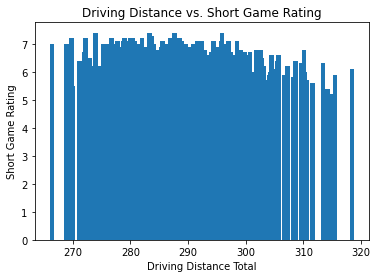

In [16]:
Short_2010_2012= cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"].isin(["2010","2011", "2012"])]

                                        
# Create bar graph
plt.bar(Short_2010_2012["Driving Distance - (AVG.)"],Short_2010_2012["Short Game Rating - (RATING)"])
plt.title("Driving Distance vs. Short Game Rating")
plt.xlabel("Driving Distance Total")
plt.ylabel("Short Game Rating")
plt.show()

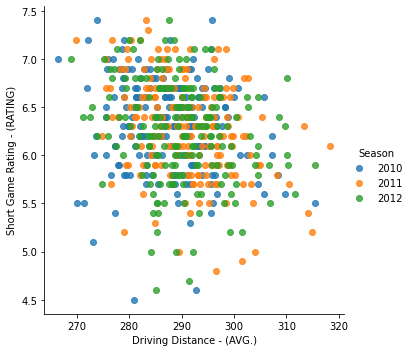

In [18]:


sns.lmplot(x = 'Driving Distance - (AVG.)', y = 'Short Game Rating - (RATING)',\
           data=Short_2010_2012[(Short_2010_2012["Driving Distance - (AVG.)"]  != 0) &\
                         (Short_2010_2012.Season.isin(['2010', '2011', '2012']))], hue = 'Season', \
                          fit_reg = False);